*Transition Perlin -> FBM*

# Simulation physique de l'érosion sur un bruit de Perlin
*Basé sur https://hal.inria.fr/inria-00402079/document*

In [2]:
import numpy as np
import perlin2D as perlin
import matplotlib.pyplot as plt


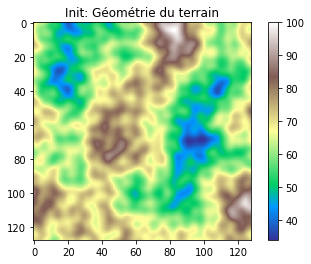

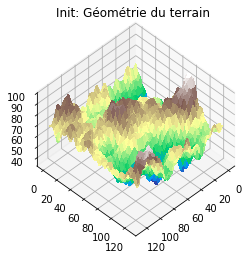

/tmp/ipykernel_160/1536399623.py:120: RuntimeWarning: divide by zero encountered in true_divide
  K = np.minimum(1, (d1 * 1 * 1) / ((fL+fR+fT+fB)*dt))
/tmp/ipykernel_160/1536399623.py:120: RuntimeWarning: invalid value encountered in true_divide
  K = np.minimum(1, (d1 * 1 * 1) / ((fL+fR+fT+fB)*dt))
/tmp/ipykernel_160/1536399623.py:151: RuntimeWarning: invalid value encountered in true_divide
  ux = 2*deltaWx/(1*(d1+d2))
/tmp/ipykernel_160/1536399623.py:163: RuntimeWarning: divide by zero encountered in true_divide
  uy = 2*deltaWy/(1*(d1+d2))
/tmp/ipykernel_160/1536399623.py:163: RuntimeWarning: invalid value encountered in true_divide
  uy = 2*deltaWy/(1*(d1+d2))


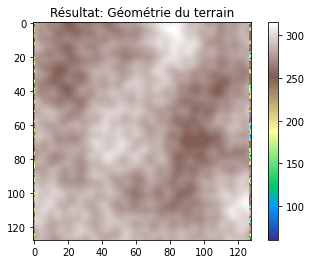

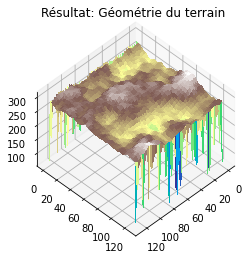

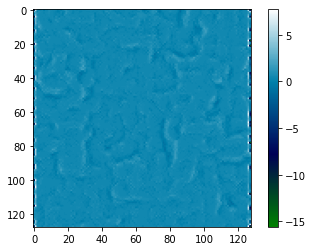

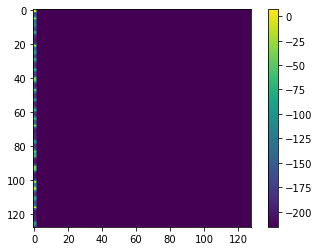

In [12]:
class ErosionSimulation:
    def __init__(self, iterations, dt = 1):
        #Taille de notre terrain
        self.shape = 2**7
        shape = self.shape
        self.iterations = iterations
        #Géométrie de notre terrain
        noise = perlin.Perlin2D([shape,shape],[2**1,2**1]).fractal2D(octaves=3, persistance=0.5, exponentiation=1, lacunarity=2) * 100
        self.dt = dt
        #Hauteur du terrain
        self.b = noise
        #Eau
        self.d = np.zeros([shape,shape])
        #Quantité de sédiment
        self.s = np.zeros([shape,shape])
        #Flux sortant des cellules dans les 4 directions
        #<,>,^,v
        self.f = np.array([[(0,0,0,0) for i in range(shape)] for j in range(shape)])
        #Vitesse (u,v)
        self.v = np.array([[(0,0) for i in range(shape)] for j in range(shape)])
        
        plt.imshow(noise,cmap="terrain")
        plt.colorbar()
        plt.title("Init: Géométrie du terrain")
        plt.show()
        
        X, Y = np.mgrid[0:shape, 0:shape]
        fig = plt.figure(figsize = (4,4))
        ax = plt.axes(projection ='3d')
        ax.set_proj_type('ortho')
        ax.view_init(45, 45)
        plt.title('Init: Géométrie du terrain')
        ax.plot_surface(X, Y, self.b, cmap="terrain",linewidth=0, antialiased=False)
        plt.show()
        
    
    def launchSimulation(self):
        b =self.b
        d = self.d
        s = self.s
        f = self.f
        v = self.v
        for i in range(self.iterations):
            b,d,s,f,v = self.simulate(b,d,s,f,v)
            
        plt.imshow(b,cmap="terrain")
        plt.colorbar()
        plt.title("Résultat: Géométrie du terrain")
        plt.show()
        
        X, Y = np.mgrid[0:self.shape, 0:self.shape]
        fig = plt.figure(figsize = (4,4))
        ax = plt.axes(projection ='3d')
        ax.set_proj_type('ortho')
        ax.view_init(45, 45)
        plt.title('Résultat: Géométrie du terrain')
        ax.plot_surface(X, Y, b, cmap="terrain",linewidth=0, antialiased=False)
        plt.show()
        
        return (b,d,s,f,v)
    
    def simulate(self,b,d,s,f,v):
        shape = self.shape
        dt = self.dt
        
        #La pluie rajoute de l'eau
        def stape1(dt,d):
            #Sources d'eau / Pluie
            r = np.random.random([shape,shape]) > 0.1

            return d + dt * r
        
        
        
        #Le courant est simulé avec un model (shallow-water model / pipe model) puis en conséquence les champs de vitesse et de l'eau changent
        def stape2(d1,b,f):
            A = 0.1
            l = 0.2
            g = 1

            fL = f[:,:,0]
            fR = f[:,:,1]
            fT = f[:,:,2]
            fB = f[:,:,3]

            deltaL = b + d
            for x in range(shape):
                for y in range(shape):
                    if(x <= 0):
                        deltaL[x][y] = 0
                        continue
                    deltaL[x][y] = deltaL[x][y] -b[x-1][y] -d1[x-1][y]

            fL = np.maximum(0,fL + dt * A * (g*deltaL)/l)
            deltaR = b + d
            for x in range(shape):
                for y in range(shape):
                    if(x >= shape-1):
                        deltaR[x][y] = 0
                        continue
                    deltaR[x][y] = deltaR[x][y] -b[x+1][y] -d1[x+1][y]
            fR = np.maximum(0,fR + dt * A * (g*deltaR)/l)
            deltaT = b + d
            for x in range(shape):
                for y in range(shape):
                    if(y >= shape-1):
                        deltaT[x][y] = 0
                        continue
                    deltaT[x][y] = deltaT[x][y] -b[x][y+1] -d1[x][y+1]
            fT = np.maximum(0,fT + dt * A * (g*deltaT)/l)
            deltaB = b + d
            for x in range(shape):
                for y in range(shape):
                    if(y <= 0):
                        deltaB[x][y] = 0
                        continue
                    deltaB[x][y] = deltaB[x][y] -b[x][y-1] -d1[x][y-1]
            fB = np.maximum(0,fB + dt * A * (g*deltaB)/l)

            K = np.minimum(1, (d1 * 1 * 1) / ((fL+fR+fT+fB)*dt))

            volume_change = np.zeros([shape,shape])
            for x in range(shape):
                for y in range(shape):

                    #inflow
                    coefR,coefL,coefT,coefB = (0,0,0,0)
                    if(x > 0):
                        coefR = fR[x-1][y]
                    if(x < shape-1):
                        coefL = fL[x+1][y]
                    if(y > 0):
                        coefT = fT[x][y-1]
                    if(y < shape-1):
                        coefB = fB[x][y+1]

                    volume_change[x][y] = dt*(coefR+coefL+coefT+coefB-fR[x][y]-fL[x][y]-fT[x][y]-fB[x][y])

            d2 = d1 + volume_change/(1*1)

            deltaWx = np.zeros([shape,shape])
            for x in range(shape):
                for y in range(shape):
                    coefR,coefL = (0,0)
                    if(x > 0):
                        coefR = fR[x-1][y]
                    if(x < shape-1):
                        coefL = fL[x+1][y]
                    deltaWx[x][y] = (coefR-fL[x][y] + fR[x][y]-coefL)/2

            ux = 2*deltaWx/(1*(d1+d2))

            deltaWy = np.zeros([shape,shape])
            for x in range(shape):
                for y in range(shape):
                    coefT,coefB = (0,0)
                    if(y > 0):
                        coefT = fR[x][y-1]
                    if(y < shape-1):
                        coefB = fL[x][y+1]
                    deltaWy[x][y] = (coefT-fB[x][y] + fT[x][y]-coefB)/2

            uy = 2*deltaWy/(1*(d1+d2))

            fdt = np.array([[(0,0,0,0) for i in range(shape)] for j in range(shape)])
            for x in range(shape):
                for y in range(shape):
                    try:
                        fdt[x][y] = (fL[x][y],fR[x][y],fT[x][y],fB[x][y])
                    except:
                        fdt[x][y] = f[x][y]

            return (d2, fdt, np.array([[(ux[x][y],uy[x][y]) for i in range(shape)] for j in range(shape)]))
        
        def stape3(vdt,b,s):

            #local angle
            db_dx = np.zeros([shape,shape])
            db_dy = np.zeros([shape,shape])
            for x in range(shape):
                for y in range(shape):
                    if(not(x >= shape-1 or x <= 0)):
                        db_dx[x][y] = (b[x+1][y]-b[x-1][y])/2
                    if(not(y >= shape-1 or y <= 0)):
                        db_dy[x][y] = (b[x,y+1]-b[x,y-1]/2)

            sin_alpha = np.sqrt((db_dx**2)+(db_dy**2))/np.sqrt(1+(db_dx**2)+(db_dy**2))

            #Sediment Capacity
            Kc = 1

            C = Kc * sin_alpha * np.sqrt((vdt[:,:,0]**2)+(vdt[:,:,1]**2))
            #Dissolving constant
            Ks = 10

            bdt = np.zeros([shape,shape])
            s1 = np.zeros([shape,shape])
            for x in range(shape):
                for y in range(shape):
                    if(C[x][y] > s[x][y]):
                        bdt[x][y]=b[x][y]-Ks*(C[x][y]-s[x][y])
                        s1[x][y]=s[x][y]+Ks*(C[x][y]-s[x][y])
                    else:
                        bdt[x][y]=b[x][y]+Ks*(-C[x][y]+s[x][y])
                        s1[x][y]=s[x][y]-Ks*(-C[x][y]+s[x][y])

            return (bdt,s1)
        
        def stape4(dt,s1,vdt):
            ux= vdt[:,:,0]
            uy = vdt[:,:,1]

            sdt = np.zeros([shape,shape])
            for x in range(shape):
                for y in range(shape):
                    i1,i2 = (x-ux[x][y]*dt,y-uy[x][y])
                    if(i1 < 0): 
                        i1 =0
                    if(i2 < 0):
                        i2 = 0
                    if(i1 >= shape):
                        i1 = shape-1
                    if(i2 >= shape):
                        i2 = shape-1
                    sdt[x][y] = s1[int(i1)][int(i2)]

            return sdt
        
        def stape5(dt,d2):
            #Evaporation Constant
            Ke = 0.5

            ddt = d2 * (1-Ke*dt)
            return ddt

 

        
        #La pluie rajoute de l'eau
        d1 = stape1(dt,d)
        
        d2,fdt,vdt = stape2(d1,b,f)
        
        bdt,s1 = stape3(vdt,b,s)
        
        sdt = stape4(dt,s1,vdt)

        
        ddt = stape5(dt,d2)
        
        return (bdt,ddt,sdt,fdt,vdt)
    
    
    
    
simu = ErosionSimulation(4,1.5)
b,d,s,f,v = simu.launchSimulation()

plt.imshow(d, cmap="ocean")
plt.colorbar()
plt.show()

plt.imshow(s)
plt.colorbar()
    